# Lab02 - Prediccion y Clasificacion

Configuracion de librerias y Ruta de trabajo

In [1]:
library(dplyr)
library(caTools)
library(class)
library(e1071)
library(rpart)
library(rpart.plot)
library(tree)
library(randomForest)
#current_dir <- dirname(rstudioapi::getSourceEditorContext()$path)
setwd("/root/Documentos/UN/UN_2020_2/DCD/module_5/class_2/jupyter")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine




## Cargar el set de datos
Vamos a continuar usando el set de datos que limpiamos y transformamos en el [laboratorio pasado](https://gtzambranop.github.io/UN_2020_2/DCD/module_5/class_1/jupyter/lab01r_preprocessing.html) en donde se registran los atributos de varias botellas de vino junto con su calidad.  De esta forma usaremos el mismo dataset a lo largo de todo el flujo del curso como si se tratara de un proyecto real!

In [2]:
wine_df <- read.csv('data/winequality-white_clean.csv', header = T, fileEncoding = 'utf-8')
glimpse(wine_df)

Registered S3 method overwritten by 'cli':
  method     from
  print.tree tree



Rows: 4,461
Columns: 12
$ fixed_acidity        <dbl> 7.0, 6.3, 8.1, 7.2, 7.2, 8.1, 6.2, 7.0, 6.3, 8.1…
$ volatile_acidity     <dbl> 0.27, 0.30, 0.28, 0.23, 0.23, 0.28, 0.32, 0.27, …
$ citric_acid          <dbl> 0.36, 0.34, 0.40, 0.32, 0.32, 0.40, 0.16, 0.36, …
$ residual_sugar       <dbl> 20.7, 1.6, 6.9, 8.5, 8.5, 6.9, 7.0, 20.7, 1.6, 1…
$ chlorides            <dbl> 0.045, 0.049, 0.050, 0.058, 0.058, 0.050, 0.045,…
$ free_sulfur_dioxide  <dbl> 45, 14, 30, 47, 47, 30, 30, 45, 14, 28, 17, 16, …
$ total_sulfur_dioxide <dbl> 170, 132, 97, 186, 186, 97, 136, 170, 132, 129, …
$ density              <dbl> 1.0010, 0.9940, 0.9951, 0.9956, 0.9956, 0.9951, …
$ pH                   <dbl> 3.00, 3.30, 3.26, 3.19, 3.19, 3.26, 3.18, 3.00, …
$ sulphates            <dbl> 0.45, 0.49, 0.44, 0.40, 0.40, 0.44, 0.47, 0.45, …
$ alcohol              <dbl> 8.8, 9.5, 10.1, 9.9, 9.9, 10.1, 9.6, 8.8, 9.5, 1…
$ score                <dbl> 6.15, 6.67, 6.48, 6.74, 6.45, 6.26, 6.70, 6.41, …


## 2a. Prediccion  
Ya hemos visto los conceptos basicos de una regresion: 
- Aprendizaje **supervisado**
- Predecir una variable **continua**
- Se busca encontrar los **pesos** de las variables para validar cada una de ellas como influye en nuestra variable final  

Lo primero que debemos hacer es separar nuestra variable objetivo (*score*) de las variables predictivas (En este caso son todas las demas, excepto *high_quality* que sera nuestra variable objetivo en el laboratorio de clasificacion)

In [3]:
x = wine_df[, !names(wine_df) %in% c("score")] 
y = wine_df['score']

In [4]:
set.seed(42) 
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
test_df  = subset(wine_df, sample == FALSE)

### OLS (Ordinary Least Squares)

Llamado asi porque busca los coeficientes de la ecuacion que minimizen la suma de las distancias verticales entre los datos y el modelo.  Para aplicar este modelo se debe validar que no haya multicolinealidad entre las variables predictivas, pues no la detecta facilmente.
![OLS](https://miro.medium.com/max/3268/1*AwC1WRm7jtldUcNMJTWmiA.png)

- **Precision:** Alta, para variables no correlacionadas (Condiciones para OLS [aqui](https://statisticsbyjim.com/regression/ols-linear-regression-assumptions))
- **Velocidad:** Rapido
- **Explicativo:** Mucho (Peso/Importancia de cada variable)
- **Sensible a cambios:** Poco, OLS crea una estimacion genralizada a todos los puntos, un solo valor atipico modificara los pesos de las variables pero no drasticamente, pues seguira convergiendo a los demas puntos
- **Deteministico**: Si

In [5]:
names(wine_df)

[1] "fixed_acidity"        "volatile_acidity"     "citric_acid"         
 [4] "residual_sugar"       "chlorides"            "free_sulfur_dioxide" 
 [7] "total_sulfur_dioxide" "density"              "pH"                  
[10] "sulphates"            "alcohol"              "score"

Empecemos con un modelo sencillo: una regresion sobre una sola variable.  Elija una de las columnas predictivas y usemosla como onica variable predictiva.  *Ej: chlorides*

In [6]:
model_ols <- lm(formula=score ~ chlorides, data = wine_df)

En el caso de **una** variable predictiva y una variable objetivo, podemos ver graficamente el comportamiento de nuestro modelo:

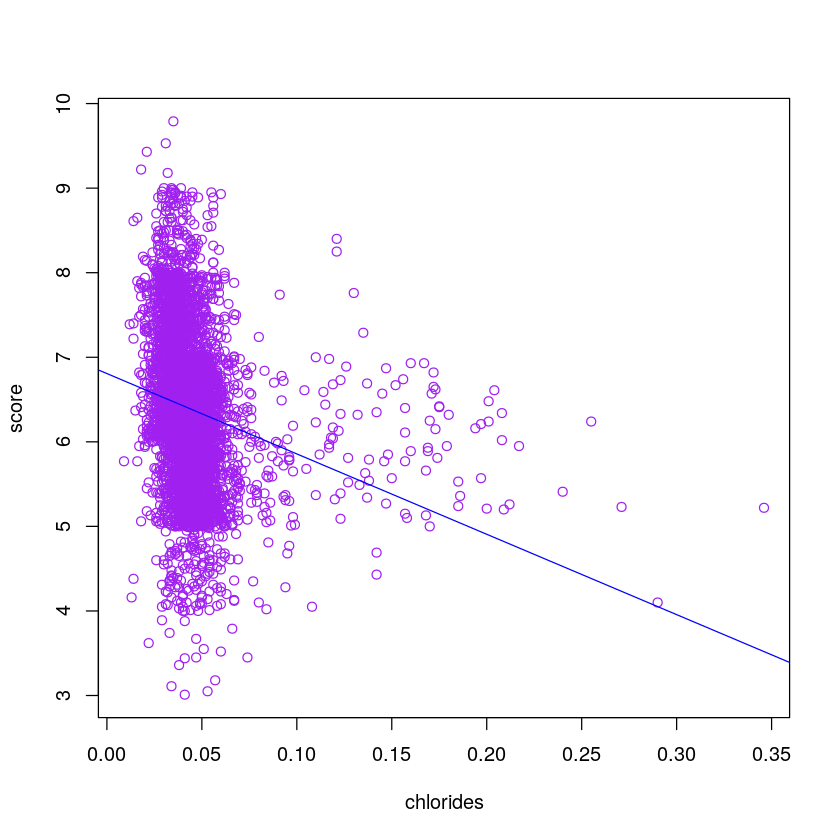

In [7]:
plot(wine_df$chlorides, wine_df$score, type='p', col='purple', xlab='chlorides', ylab='score')
abline(model_ols, col = 'blue')

Con una sola variable es posible que el modelo no se ajuste correctamente a los datos, podemos ver que daria predicciones erradas.  Podemos incluir otras variables al modelo que nos permitan darle mas flexibilidad a l ecuacion

En el parametro para *lm()* se le indica al modelo que necesitamos una funcion de la forma:
> Y ~ X1 + X2 + X3 + X4 + ... + Xn  

En donde Y es nuestra variale objetivo y cada Xi son las variables predictivas para las que se debe buscar un peso en la ecuacion.

In [8]:
model_ols <- lm(formula=score ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar +
                chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH+
                sulphates + alcohol, data = wine_df)
model_ols


Call:
lm(formula = score ~ fixed_acidity + volatile_acidity + citric_acid + 
    residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + 
    density + pH + sulphates + alcohol, data = wine_df)

Coefficients:
         (Intercept)         fixed_acidity      volatile_acidity  
           1.535e+02             1.088e-01            -1.673e+00  
         citric_acid        residual_sugar             chlorides  
           1.496e-01             8.126e-02            -5.376e-01  
 free_sulfur_dioxide  total_sulfur_dioxide               density  
           4.251e-03            -6.263e-04            -1.543e+02  
                  pH             sulphates               alcohol  
           8.969e-01             6.693e-01             2.012e-01  


In [9]:
# Entrega tambien distribucion de residuales
summary(model_ols) 


Call:
lm(formula = score ~ fixed_acidity + volatile_acidity + citric_acid + 
    residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + 
    density + pH + sulphates + alcohol, data = wine_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9119 -0.5214 -0.0068  0.5156  3.3193 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.535e+02  2.050e+01   7.488 8.41e-14 ***
fixed_acidity         1.088e-01  2.359e-02   4.611 4.12e-06 ***
volatile_acidity     -1.673e+00  1.267e-01 -13.209  < 2e-16 ***
citric_acid           1.496e-01  1.091e-01   1.371    0.170    
residual_sugar        8.126e-02  8.256e-03   9.843  < 2e-16 ***
chlorides            -5.376e-01  6.369e-01  -0.844    0.399    
free_sulfur_dioxide   4.251e-03  9.410e-04   4.517 6.43e-06 ***
total_sulfur_dioxide -6.263e-04  4.191e-04  -1.494    0.135    
density              -1.543e+02  2.081e+01  -7.412 1.48e-13 ***
pH                    8.969e-01  1.246

In [10]:
# Intervalos de confianza
confint(model_ols) 

,2.5 %,97.5 %
(Intercept),1.133245e+02,1.937185e+02
fixed_acidity,6.251938e-02,1.549984e-01
volatile_acidity,-1.921361e+00,-1.424741e+00
citric_acid,-6.426672e-02,3.633694e-01
residual_sugar,6.507689e-02,9.744724e-02
chlorides,-1.786302e+00,7.110670e-01
free_sulfur_dioxide,2.405892e-03,6.095637e-03
total_sulfur_dioxide,-1.448068e-03,1.954103e-04
density,-1.950783e+02,-1.134674e+02
pH,6.526795e-01,1.141094e+00


La funcion *summary()* nos entrega un monton de informacion, vamos a analizar las que mas nos interesan:  

- Modelo utilizado (OLS) y distribucion de residuales *(Un dato que no entrega el summary de Python)*
- Degrees of Freedom (Flexibilidad del modelo: #Observacionnes - #Variables) y Df modelo (#Variables -Intercepto)
- R-squared o R2, los datos de la parte inferior, es el cuadrado del coeficiente de correlacion de todas las variables y representa el porcentaje estimado de varianza que puede ser explicado por el modelo.  
- Adjusted R-squared es un R2 que penaliza coeficientes muy grandes o muy bajos y variables redundantes.  

- La tabla del centro nos muestra los coeficientes encontrados por el modelo para cada variable, junto con el error estandar de cada uno.  Esto significa que nuestro modelo tiene la forma:
$$
y = 153.5215 + 0.1088(fixed acidity) - 1.6731(volatile acidity) + ... + 0.2012(alcohol)
$$

- Los valores t y valores P (*Pr>|t|*), para cada variable, indican si esta afecta o no la variable objetivo.  Son valores estadisticos, por lo general se busca que P < 0.05
- La funcion *confint()* nos entrega los intervalos de confianza de cada variable [0.025 - 0.975]

Por ahora, vamos a trabajar con estos valores para mejorar nuestro modelo.  Si quieres saber en detalle el significado y el impacto de modificar cada uno de estos resultados, puedes leer mas [aqui](https://www.institutomora.edu.mx/testU/SitePages/martinpaladino/modelos_lineales_con_R.html)

**Taller**  
Juegue un poco con las variables en la funcion *lm()* para ver si logra aumentar el R2 del modelo.  Por ejemplo:

- Revise las variables que, segon el  [laboratorio pasado](./Lab01r_Preprocesamiento.Rmd) estan correlacionadas entre si y aquellas que estan correlacionadas con la variabe objetivo
- Revise las variables que, segon el modelo afectan la variable objetivo (*P valores*)  

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [11]:
saveRDS(model_ols, file = "models/model_ols.rds")

### Modelos Polinomiales  
A diferencia de Python, algunos modelos en R pueden ser configurados para que *busquen una formula* usando las variables que se indican por parametro como hicimos en el ejercicio anterior.  
De igual manera, podemos dividir el dataset en entrenamiento y prueba y **diferenciar las variables predictivas (x) de la variable objetivo (y)**, para no "mostrarlas" al modelo en la fase de pruebas:

In [12]:
set.seed(42) 
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
test_df  = subset(wine_df, sample == FALSE)

columnas = c('residual_sugar', 'alcohol', 'citric_acid')
x_train = train_df[columnas]
x_test = test_df[columnas]
y_train = train_df['score']
y_test = test_df['score']

In [13]:
model_poly = lm(formula=score ~ polym(residual_sugar, alcohol, citric_acid, degree=2, raw=T), 
                data = train_df)
summary(model_poly)


Call:
lm(formula = score ~ polym(residual_sugar, alcohol, citric_acid, 
    degree = 2, raw = T), data = train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5959 -0.5274 -0.0188  0.5446  3.2767 

Coefficients:
                                                                        Estimate
(Intercept)                                                            0.2341845
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)1.0.0  0.1449820
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)2.0.0 -0.0014103
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)0.1.0  0.6210591
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)1.1.0 -0.0090879
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)0.2.0 -0.0098166
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)0.0.1  1.7088651
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)1.0.1 -0.0219833
polym(residual_sugar, alcohol, citric_acid, de

En celdas anteriores hemos dividido el conjunto de datos en dos subconjuntos: Entrenamiento y Prueba.  
Ahora, hemos tomado solo tres de ellas (*residual_sugar, alcohol, citric_acid*), para el ejemplo y creado y entrenado un modelo polinomial usando onicamente el set de entrenamiento, y hemos calculado el $R2$ (*score*) usando el set de pruebas: **22%**, el modelo aon puede mejorar, esto lo haremos mas adelante.  
Pero cual es este modelo/ecuacion que hemos creado, asi como lo vimos en la seccion pasada?

In [14]:
model_poly


Call:
lm(formula = score ~ polym(residual_sugar, alcohol, citric_acid, 
    degree = 2, raw = T), data = train_df)

Coefficients:
                                                          (Intercept)  
                                                             0.234184  
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)1.0.0  
                                                             0.144982  
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)2.0.0  
                                                            -0.001410  
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)0.1.0  
                                                             0.621059  
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)1.1.0  
                                                            -0.009088  
polym(residual_sugar, alcohol, citric_acid, degree = 2, raw = T)0.2.0  
                                                            -0.009817  
polym

Parecen ser muchos? Porque? Como saber a que variable corresponde cada uno?  
La funcion anterior, imprimir el contenido del modelo, nos muestra, no solo los coeficientes, sino la "combinacion" de variables (exponentes) que afecta cada uno (Por ejemplo 1.1.0 significa $residual sugar^1 * alcohol^1 * citricacid^0$, mientras que 2.0.0 significa $residual sugar^2 * alcohol^0 * citricacid^0$ y asi sucesivamente)  
Pero no es necesario realizar este calculo cada vez que queramos predecir un dato nuevo. El modelo nos entrega predicciones de un nuevo set de datos usando la funcion *predict*

In [15]:
predict(model_poly, x_test)

1        6        7        8       11       14       15       23 
6.041640 6.324965 5.916581 6.041640 6.081582 6.685413 5.442057 6.102105 
      26       33       34       38       50       53       60       65 
6.507594 6.331038 7.273483 5.977262 6.429147 5.678198 5.931123 7.079111 
      69       73       79       83       85       86       88       89 
5.925659 6.114540 6.093891 5.822856 5.855085 5.847164 5.916011 7.121241 
      93       97       98      103      115      124      125      132 
5.896279 6.079890 6.084979 6.132476 6.116528 6.146087 6.050928 6.863718 
     139      142      143      147      149      160      171      174 
6.040598 6.847814 6.330191 6.452819 6.934721 6.425996 6.308420 5.835714 
     176      177      187      192      194      195      197      201 
6.801326 6.040045 6.977875 5.795080 6.600303 5.974840 6.434084 6.147583 
     204      206      209      211      212      217      220      236 
5.875476 5.600734 5.960490 5.960490 6.008689 6.065865 6.227433 6.884662 
     238      242      244      249      253      256      258      259 
5.906044 6.667629 6.392318 5.808689 6.082890 6.260991 6.312539 7.179121 
     260      269      270      272      287      298      299      300 
7.166491 5.424545 5.726533 6.701125 6.193397 6.495546 6.748010 6.394844 
     301      307      308      312      313      314      319      321 
6.137453 6.252303 6.457112 6.271252 6.161276 5.925659 6.014739 6.020531 
     324      325      336      337      339      341      343      345 
6.687916 6.987445 7.030521 6.338734 6.418861 5.644375 5.867529 6.946067 
     347      348      351      359      364      374      379      380 
6.182966 6.117850 6.117850 6.076873 7.046494 5.988124 6.218674 6.717249 
     384      388      390      392      394      399      405      413 
6.240367 6.228908 6.398444 6.396452 6.398444 6.189823 6.007542 6.615628 
     414      423      424      426      432      433      434      435 
6.826859 6.239445 6.241441 5.941617 6.071278 5.704886 5.831057 6.258120 
     440      441      443      444      450      451      454      462 
5.821893 6.191528 6.238617 6.004966 5.957148 6.300966 6.939125 6.045867 
     464      465      469      471      482      485      489      500 
6.226116 6.230637 5.962240 6.019505 6.364296 5.932107 5.827848 6.103035 
     502      509      525      529      530      534      540      541 
6.203498 5.937340 5.766095 6.071302 5.904910 7.184647 6.999399 5.791383 
     543      544      545      550      552      553      554      556 
6.166654 6.080038 5.830601 6.105553 6.105553 6.531192 6.482976 5.806353 
     563      565      566      569      577      578      582      585 
5.773001 6.789585 6.394000 6.096932 6.261690 6.041345 6.485117 6.015886 
     594      599      600      605      607      613      614      617 
5.784789 6.087428 6.087428 6.082744 5.849800 5.721762 7.118565 6.130517 
     637      638      646      647      651      652      654      657 
6.447186 6.127001 6.233520 6.203215 6.209110 7.074150 6.711416 6.114000 
     667      670      675      678      679      683      686      688 
6.296146 6.500655 6.497000 6.066545 5.962810 6.455684 6.453563 6.096978 
     692      694      698      700      703      704      708      710 
6.853921 6.824046 6.477390 7.047387 6.004784 6.004784 6.107040 6.047409 
     712      723      729      739      744      745      746      752 
6.040221 6.000276 6.038270 5.814639 5.940483 6.018563 6.112864 5.862597 
     756      757      765      766      768      774      776      780 
5.597611 6.226101 5.846393 5.979431 6.203592 6.826194 6.968206 6.886194 
     781      787      808      810      811      812      814      817 
6.886194 6.446563 7.092497 5.862788 6.073330 6.053068 5.822710 6.080347 
     819      820      822      828      829      831      835      838 
6.157691 5.623389 6.080347 6.629595 6.489571 6.489571 6.918921 6.433939 
     840      846      852      854      857      858      859   

**Taller**  
Juegue un poco con las variables a incluir o no en el modelo, asi como el grado de la regresion polinomial para ver si logra aumentar el score del modelo.

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [16]:
saveRDS(model_poly, file = "models/model_poly.rds")

## 2b. Clasificacion  
Ya hemos visto porque una regresion lineal es diferente a una clasificacion, tanto en el concepto como matematicamente: 
- Predecir una variable **categorica**
- Se busca encontrar los patrones o similitudes entre cada *clase* para poder clasificar despues un registro nuevo  

Sin embargo, al igual que en la Prediccion, lo primero que debemos hacer es dividir el dataset en entrenamiento y pruebas y separar nuestra variable objetivo (*high_quality*) de las variables predictivas (En este caso son todas las demas, excepto *score* que fue nuestra variable objetivo en el laboratorio de prediccion)

In [17]:
wine_df <- read.csv('data/winequality-red_clean.csv', header = T, fileEncoding = 'utf-8')
glimpse(wine_df)

Rows: 1,571
Columns: 12
$ fixed_acidity        <dbl> 7.4, 7.8, 7.8, 11.2, 7.4, 7.4, 7.9, 7.3, 7.8, 7.…
$ volatile_acidity     <dbl> 0.700, 0.880, 0.760, 0.280, 0.700, 0.660, 0.600,…
$ citric_acid          <dbl> 0.00, 0.00, 0.04, 0.56, 0.00, 0.00, 0.06, 0.00, …
$ residual_sugar       <dbl> 1.9, 2.6, 2.3, 1.9, 1.9, 1.8, 1.6, 1.2, 2.0, 6.1…
$ chlorides            <dbl> 0.076, 0.098, 0.092, 0.075, 0.076, 0.075, 0.069,…
$ free_sulfur_dioxide  <dbl> 11, 25, 15, 17, 11, 13, 15, 15, 9, 17, 15, 17, 1…
$ total_sulfur_dioxide <dbl> 34, 67, 54, 60, 34, 40, 59, 21, 18, 102, 65, 102…
$ density              <dbl> 0.9978, 0.9968, 0.9970, 0.9980, 0.9978, 0.9978, …
$ pH                   <dbl> 3.51, 3.20, 3.26, 3.16, 3.51, 3.51, 3.30, 3.39, …
$ sulphates            <dbl> 0.56, 0.68, 0.65, 0.58, 0.56, 0.56, 0.46, 0.47, …
$ alcohol              <dbl> 9.4, 9.8, 9.8, 9.8, 9.4, 9.4, 9.4, 10.0, 9.5, 10…
$ high_quality         <int> 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, …


In [18]:
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
test_df  = subset(wine_df, sample == FALSE)

columnas = c('pH', 'alcohol')
x_train = train_df[columnas]
x_test = test_df[columnas]
y_train = train_df['high_quality']
y_test = test_df['high_quality']

### Regresion Logistica

Similar a una regresion lineal, busca definir el comportamiento de los datos a traves de una **ecuacion**, con la diferencia que en este caso estamos buscando una variable categorica (1/0 o SI/NO), por lo que no nos serviria una ecuacion que retorne un valor entre $(-\infty, \infty)$.  
Sin embago, al ser una ecuacion, asume que los datos son linealmente separables:

![](https://qph.fs.quoracdn.net/main-qimg-4ddda954955cabf0fb59364cc37232b7.webp)

- **Precision:** Alta, para variables no correlacionadas y modelos linealmente separables
- **Velocidad:** Rapido
- **Explicativo:** Mucho (Peso/Importancia de cada variable)
- **Sensible a cambios:** Mucho, asume que los datos son separables linealmente
- **Deteministico**: No, probabilistico

Como el hecho de que sean datos linealmente separables es **muy** importante, vamos a crear un modelo con solo **dos** variables precitivas para poder ver la separacion graficamente:

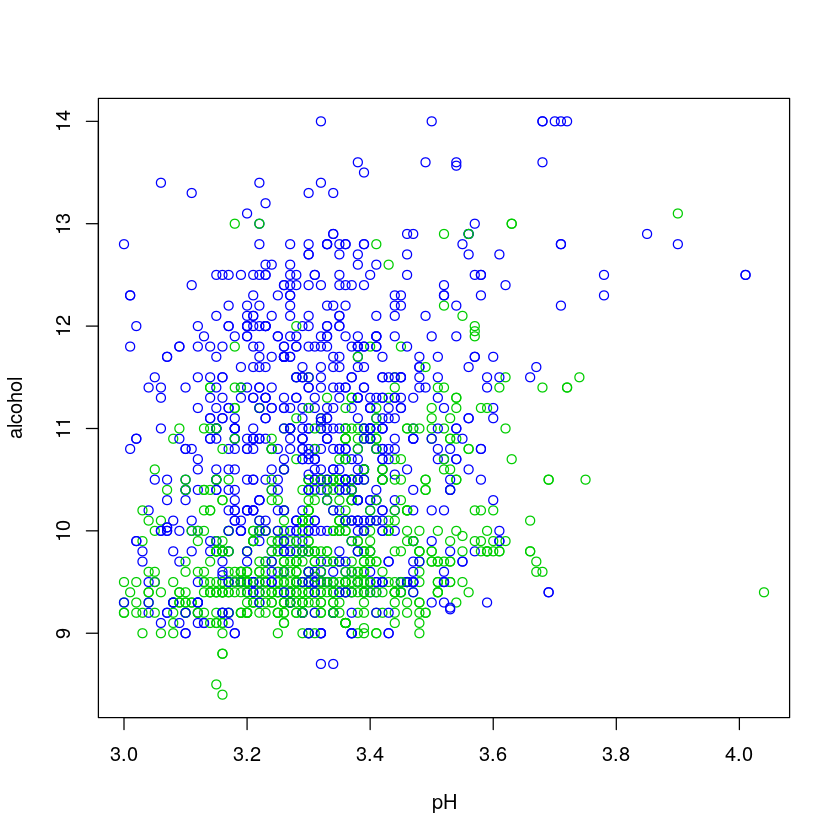

In [19]:
with(wine_df, plot(pH, alcohol, col=high_quality+3))

En este caso, nuestra variable predictiva *high_quality*, representada por el color de los puntos, parece ser linealmente separable por la variable *alcohol*, pero no tanto por la variable *pH*.  

Como afecta esto al modelo?

In [20]:
model_log = glm(formula=high_quality ~ pH + alcohol, 
                data = train_df, family=binomial(link="logit"))
model_log


Call:  glm(formula = high_quality ~ pH + alcohol, family = binomial(link = "logit"), 
    data = train_df)

Coefficients:
(Intercept)           pH      alcohol  
     -6.494       -1.802        1.224  

Degrees of Freedom: 1183 Total (i.e. Null);  1181 Residual
Null Deviance:	    1634 
Residual Deviance: 1332 	AIC: 1338

Nuevamente hemos entrenado el modelo con los datos de entrenamiento y calculamos el error con datos de entrenamiento, aunque no parece un score tan malo, veamos como se comporta el modelo:

In [21]:
proba <- predict(model_log, x_test, type="response")
proba

6        12        18        26        42        44        45        57 
0.2122222 0.5802107 0.3289289 0.2446040 0.2722169 0.5421210 0.2432268 0.4453332 
       68        69        71        75        77        79        80        82 
0.6001988 0.6670091 0.3001309 0.3425081 0.4952925 0.4451737 0.2596027 0.3482718 
       84        86        97        98       101       111       114       115 
0.3361010 0.4318605 0.1942201 0.4665995 0.2386824 0.3539326 0.4108013 0.2574554 
      121       122       123       129       130       131       132       133 
0.2567422 0.2743133 0.3361010 0.9468446 0.9468446 0.3489732 0.4559463 0.3799136 
      138       140       141       151       155       160       163       167 
0.3799136 0.9822625 0.2679276 0.4585661 0.5492066 0.4372069 0.3515225 0.4329354 
      170       171       179       181       183       184       185       192 
0.2386824 0.8056287 0.3249625 0.1842078 0.3790343 0.2226932 0.3256404 0.3705872 
      202       210       213       219       221       227       228       232 
0.2226932 0.5519785 0.5845945 0.3401348 0.4594934 0.6764622 0.8872173 0.1886405 
      235       240       243       245       246       248       254       256 
0.2134734 0.4883106 0.2932533 0.2941619 0.3697167 0.4864448 0.2623589 0.3774299 
      260       262       265       266       267       271       275       278 
0.4327769 0.7858450 0.9585021 0.1630065 0.4900154 0.2786660 0.4900154 0.3249625 
      282       285       290       291       303       305       315       319 
0.3866695 0.5106763 0.5776373 0.4318605 0.3249625 0.3515225 0.5723200 0.3875554 
      320       321       327       331       338       342       343       348 
0.2616369 0.3154901 0.3556422 0.7912332 0.2986998 0.7277196 0.2970029 0.4292722 
      352       357       359       360       363       366       367       374 
0.9018567 0.4479423 0.3900640 0.5627143 0.5538246 0.9191303 0.3084156 0.9191303 
      376       383       396       402       409       410       415       416 
0.6820163 0.2016179 0.3606440 0.4540944 0.2686606 0.8740332 0.5985606 0.2895316 
      422       424       432       440       452       457       463       464 
0.9021297 0.6475527 0.3639456 0.5125423 0.3425081 0.9021867 0.4346111 0.7284589 
      466       468       472       476       477       482       485       495 
0.6368443 0.3202078 0.5829367 0.3859373 0.3859373 0.6780945 0.9774662 0.9230596 
      496       498       503       505       507       517       522       528 
0.9230596 0.7197658 0.8791443 0.5653102 0.9155978 0.3124121 0.1344429 0.4594934 
      530       534       535       537       540       541       542       546 
0.3648104 0.3506717 0.7664149 0.8113104 0.6749672 0.6492553 0.2933871 0.6995305 
      548       553       556       560       567       573       578       581 
0.9086776 0.4765129 0.1886405 0.7290694 0.3077573 0.6589546 0.7035747 0.3416677 
      583       587       588       599       600       601       606       614 
0.2707399 0.4346111 0.3740778 0.2074832 0.4416469 0.4082486 0.3369347 0.1964663 
      621       622       623       626       627       631       633       636 
0.3193955 0.3748012 0.3047212 0.5951220 0.2506242 0.2506242 0.4362883 0.8382978 
      639       642       643       646       650       651       653       654 
0.3979337 0.6958650 0.3264609 0.6259983 0.7852159 0.4684587 0.3681283 0.3474247 
      659       663       668       670       674       678       682       684 
0.3721800 0.3781558 0.3705872 0.2823035 0.2750573 0.2465599 0.2465599 0.3264609 
      685       694       700       704       714       716       717       719 
0.3663928 0.2679276 0.2499235 0.6980945 0.2010175 0.3233264 0.1952900 0.2412889 
      724       728       731       734       735       736       744       745 
0.3765528 0.2526121 0.3116106 0.2845787 0.5695759 0.6748255 0.3039306 0.3039306 
      749       753       754       755       760       761       766       771 
0.2993471 0.3077573 0.3039306 0.3934692

In [22]:
y_pred <- ifelse(proba > 0.5,1,0)
head(y_pred)
head(y_test)

6 12 18 26 42 44 
 0  1  0  0  0  1

,high_quality
,<int>
6,0
12,0
18,0
26,0
42,0
44,0


En R, es mas preciso calcular el error usando los datos del test de prueba, ya que el score (R2) es calculado con el test de entrenamiento

In [23]:
mean(y_pred != y_test)

[1] 0.2919897

**Taller**  
Juegue un poco con las variables a incluir en el modelo para ver si logra aumentar el score del modelo y sus predicciones.  Algunas sugerencias:

- Valide que variables permiten la separacion lineal de los datos  
- Puede incluir mas de dos variables para entrenar el modelo, es lo mas recomendable, pero recuerde que no sera posible visualizar la separacion graficamente  
- Intente con el parametro *family* de la funcion glm(), este permite generar otro tipo de lineas que pueden mejorar el modelo (Los posibles valores para el parametro y saber en detalle que tipo de modelo genera cada uno puede consultar [aqui](https://rpubs.com/JessicaP/459130).  Tenga en cuenta GLM (General Lineal Model, puede generar todo tipo de models lineales y estamos buscando un modelo de *clasificacion binaria*)

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [24]:
saveRDS(model_log, file = "models/model_log.rds")

### Vecinos mas cercanos (kNN)

Es un metodo de clasificacion para problemas **no lineales**, y tal vez con una metodologia/matematica mas sencilla.
Consiste en ver los datos como puntos en un plano (de N dimensiones cuantas variables incluya el modelo) y clasificar cualquier "punto nuevo" en la misma clase a la que pertenescan los *k* puntos mas cercanos (*k* puede ser definido por nosotros mismos)

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTIr4A7USCWANPP8HDtHIOmN2HOY_CK1PhL2Q&usqp=CAU" alt="kNN" width="400"/>

- **Precision:** Depende intensamente del valor de k.  muy eficiente para datasets sin ruido
- **Velocidad:** Depende de dimensiones (*Realmente no construye ningon modelo*)
- **Explicativo:** Mucho (Es una ecuacion sencilla)
- **Sensible a cambios:** Mucho a atributos irrelevantes y la complejidad del modelo
- **Deteministico**: Si

In [25]:
x_train = train_df[, !names(train_df) %in% c("high_quality")]
x_test = test_df[, !names(test_df) %in% c("high_quality")]
y_train = train_df$high_quality
y_test = test_df$high_quality

In [26]:
y_pred <- knn(x_train, x_test, cl=y_train, k=18)
mean(y_pred != y_test)

[1] 0.3255814

En este caso, se eligio el nomero de vecinos (k) aleatoriamente, y con razon no obtuvimos un score bueno. Pero cuidado:  

- Si k es muy pequeño, tendiendo a 1, el modelo va a decidir por la clase del ejemplo mas cercano. Esto hace el modelo muy sensible al ruido o a pequeños cambios.  
- Si k es muy grande, tendiendo a N, el modelo no podra gneralizar.  Nunca analizara patrones, reglas, ni similitudes sino que decidira siempre *lo que diga la mayoria*  

**Taller**  
Juegue un poco con el valor de k (*k* en la funcion *knn*) para mejorar el score del modelo.  
Tambien puede intentar eliminando aquellas variables que generen ruido o atipicos sobre los datos.

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [27]:
saveRDS(y_pred, file = "models/model_knn.rds")

### Maquinas de Soporte Vectorial (SVM)

Cuando hablamos de Regresion logistica, buscamos **una linea** que divida los datos de la mejor manera. Pero, que pasa cuando hay mas de una linea que cumple con esta condicion? Como elegir la mejor?  
Las maquinas de soporte vectorial buscan, por el contrario, un *hiperplano*: un conjunto de lineas que maximicen la distancia/margen entre los puntos mas cercanos de cada clase.  A estos puntos mas cercanos se les conoce como *vectores de soporte*

<img src="https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2017/08/how-svm-works.png" alt="SVM" width="400"/>

- **Precision:** Alta si se configura correctamente
- **Velocidad:** Lento para una gran cantidad de datos
- **Explicativo:** No
- **Sensible a cambios:** Si, sobretodo a ejemplos mal etiquetados
- **Deteministico**: Si

In [28]:
x_train = train_df[, !names(train_df) %in% c("high_quality")]
x_test = test_df[, !names(test_df) %in% c("high_quality")]
y_train = train_df$high_quality
y_test = train_df$high_quality

In [29]:
model_svm <- svm(x_train, y_train, kernel='radial')

In [30]:
probas <- predict(model_svm, x_test, decision.values = TRUE)
y_pred <- ifelse(probas > 0.5,1,0)
mean(y_pred != y_test)

Warning message in y_pred != y_test:
“longitud de objeto mayor no es múltiplo de la longitud de uno menor”


[1] 0.4949324

Aún tenemos un error un poco alto.  Sin embargo, una de las ventajas de SVM, a pesar de ser un algoritmo lento y sensible al ruido, es su versatilidad para manejar problemas no lineales.  Esto lo logra por medio del parametro **kernell** que permite definir "la forma" del/los hiperplano/s que va a generar:
![Kernell](https://i.imgur.com/HKTLn35.png)

**Taller**  
Juegue un poco con las columas a incluir en el modelo, asi como con el **kernel** de la funcion *svm()*.  Los posibles valores de este parametro son:

- 'linear'
- 'polynomial' (En este caso tambien se puede configurar el parametro *degree*)
- 'radial basis' (rbf)
- 'sigmoid'

Puede que enuentre varios modelos que le parezcan convenientes.  Se sugiere guardar cada uno de la siguiente manera (cambiando el nombre del archivo):

In [31]:
saveRDS(model_svm, file = "models/model_svm.rds")

### Árboles de Decision

Es el tipo de algoritmo mas facil de entender, pues se basa en reglas condicionales muy similares al lenguaje humano (*Si... entonces...*).  El entrenamiento consiste en encontrar las reglas y condiciones que cubran la mayor cantidad de casos.  
El modelo graficamente puede ser representado mediante un arbol en el que los **nodos intermedios** son decisiones basadas en alguno de los atributos predictivos, y las **hojas** son la clase objetivo.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png" alt="Decision Tree" width="400"/>

- **Precision:** Alta tendencia al sobreajuste (memorizar datos)
- **Velocidad:** Rapido. La validacion de reglas son condicionales
- **Explicativo:** Si
- **Sensible a cambios:** Si, pequeños cambios en los datos puede resultar en arboles completamente diferentes.
- **Deteministico**: No

In [32]:
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
test_df  = subset(wine_df, sample == FALSE)

In [33]:
model_tree <- rpart(high_quality ~ ., data = train_df, method = 'class')

In [34]:
y_pred = data.frame(predict(model_tree, x_test, type="class"))
mean(y_pred != y_test)

[1] 0.4883721

En cada uno de los nodos, el algoritmo valida que variable y que valor de esa variable produce un nivel mayor de "pureza" entre las hojas (*Entropia/gini index*).  Si este nivel no es suficiente para dar una buena decision, se hace una nueva particion en cada una de las hojas, validando nuevamente todas las variables predictivas.  

Por esto mismo, los arboles de decision tienen varios parametros que configurar (Nivel minimo de entropia, profundidad maxima del arbol, minima cantidad de muestras para las hojas, etc.)  
Otra de las ventajas de los arboles es que son **tan explicativos**, que pueden ser graficados para validar el proceso de toma de cada decision en el proceso de prediccion:

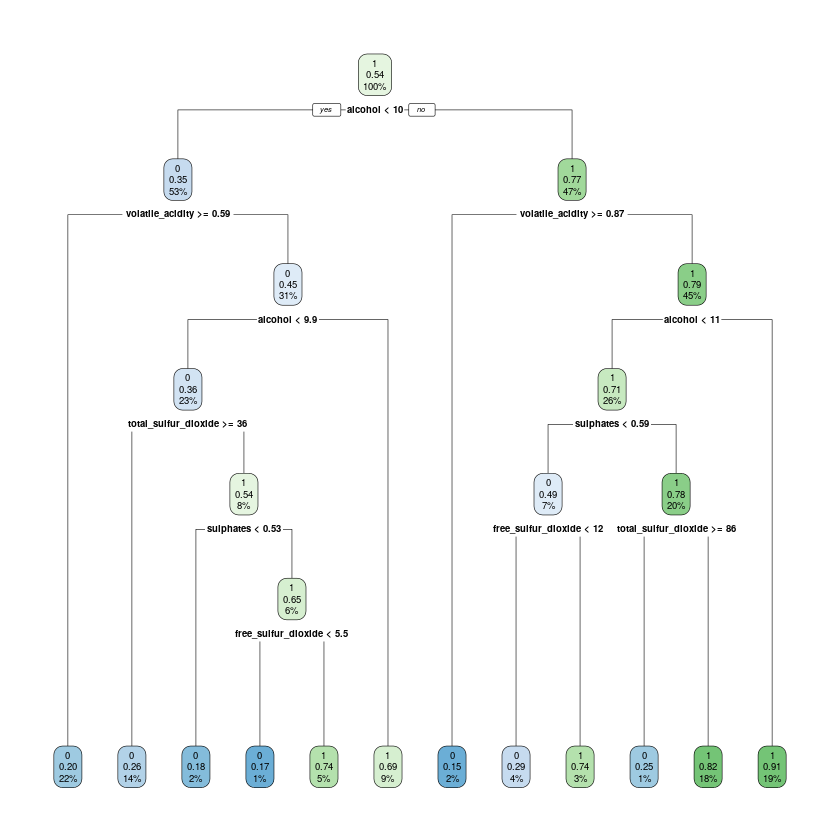

In [35]:
rpart.plot(model_tree)

**Taller**  
Juegue un poco con las columas a incluir en el modelo, asi como con los parametros de la funcion *rpart()*. Para ello es necesario llamar la funcion *rpart.control()* y configurar algunos parametros como *max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, ...*.
Para mayor infirmacion puede consultar [aqui](https://www.rdocumentation.org/packages/rpart/versions/4.1-15/topics/rpart.control).

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [36]:
saveRDS(model_tree, file = "models/model_tree.rds")

### Ensambles de Modelos
Cuando un modelo es **no deterministico**, pero tiende al **sobreajuste**, es decir, aprende de memoria las reglas y patrones del set de entrenamiento, hasta el punto de no predecir correctamente sobre el test de entrenamiento, esto puede solucionarse haciendo un ensamble o conjunto de modelos.  Esto es, construir varios modelos "debiles" y crear uno "robusto", tomando la decision final dependiendo de:

- "Democracia", el resultado es lo que diga la mayoria de modelos, realizando cada uno **bajo un set de entrenamiento diferente** (*bagging*)
- "Aleatorio", el resultado es lo que diga la mayoria de arboles de decision, realizando cada uno con un set aleatorio de  variables (*randomForest*)

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780128177365000090-f09-17-9780128177365.jpg" alt="Rnd Forest" width="500"/>

- **Precision:** Alta, varios modelos eliminan el sobreajuste
- **Velocidad:** Lento, por velocidad se sacrifica precision
- **Explicativo:** Si, aunque no entrega el modelo, entre importancia de variables
- **Sensible a cambios:** No mucho, un dato atipico peude modificar un arbol, pero no todos
- **Deteministico**: No

In [37]:
sample = sample.split(wine_df[,1], SplitRatio = .75)
train_df = subset(wine_df, sample == TRUE)
train_df$high_quality <- as.factor(train_df$high_quality)
test_df  = subset(wine_df, sample == FALSE)

In [52]:
model_forest <- randomForest(high_quality ~ ., data = train_df, 
                             type = 'classification', ntree=20)
y_pred = data.frame(predict(model_forest, x_test))
mean(y_pred != y_test)

[1] 0.498708

Note que, si la anterior celda se ejecuta varias veces, cada vez da un valor diferente.  Esto significa que el modelo es **no deterministico**.  Aunque el error cambie con solo ejecutarlo, es mejor configurar algunos parametros para indicarle al modelo por donde esta la mejor solucion.  
El concenso realizado entre los modelos permite al algoritmo, a pesar de ser no deterministico, darse una idea de la importancia de cada variable en la toma de la decision:

In [39]:
imp = importance(model_forest)
imp

,MeanDecreaseGini
fixed_acidity,37.21263
volatile_acidity,62.44334
citric_acid,35.73411
residual_sugar,30.23166
chlorides,44.02320
free_sulfur_dioxide,35.63569
total_sulfur_dioxide,56.15126
density,44.91798
pH,39.71718
sulphates,74.25979


**Taller**  
Juegue un poco con las columnas a incluir en el modelo, en este caso revise la importancia de variables.  
Puede tambien jugar con los parametros de la funcion *randomForest()*, como *ntree* (Cantidad de modelos/arboles a generar), *maxnodes. nodesize, etc.*

Una vez encuentre un modelo que considere adecuado, vamos a a guardarlo para futuros laboratorios:

In [40]:
saveRDS(model_tree, file = "models/model_tree.rds")